In [ ]:
!pip install catboost
!pip install shap
!pip install optuna
#!pip install skopt
!pip install hyperopt

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve, auc
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
import matplotlib.pyplot as plt
from sklearn import metrics
import optuna
from optuna import Trial
from hyperopt import tpe, hp, fmin, Trials
#from skopt import space, gp_minimize
from optuna.samplers import TPESampler, RandomSampler, BaseSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    return summary

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
df = pd.read_csv("term_deposit_data.csv")
orig_df = df.copy()
print ("Total number of rows in dataset = {}".format(df.shape[0]))
print ("Total number of columns in dataset = {}".format(df.shape[1]))

Total number of rows in dataset = 41188
Total number of columns in dataset = 21


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed_flag
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
result = resumetable(df)
result

Dataset Shape: (41188, 18)


,Name,dtypes,Missing,Uniques,First Value,Second Value
0,age,int64,0,78,56,57
1,job,object,0,12,housemaid,services
2,marital,object,0,4,married,married
3,education,object,0,8,basic.4y,high.school
4,default,object,0,3,no,unknown
5,housing,object,0,3,no,no
6,loan,object,0,3,no,no
7,contact,object,0,2,telephone,telephone
8,month,object,0,10,may,may
9,day_of_week,object,0,5,mon,mon


In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'subscribed_flag'],
      dtype='object')

In [ ]:
df.groupby('day_of_week').agg({'day_of_week' : 'count'})

,day_of_week
day_of_week,
fri,7827
mon,8514
thu,8623
tue,8090
wed,8134


In [ ]:
df[~df.day_of_week.isna()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed_flag
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [ ]:
orig_df[orig_df.subscribed_flag.isna()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed_flag


In [ ]:
orig_df.default.drop_duplicates()

0             no
1        unknown
21580        yes
Name: default, dtype: object

In [ ]:
df = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 
       'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'subscribed_flag']]
df = df[~df.day_of_week.isna()]       
df = df[~df.subscribed_flag.isna()]
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed_flag
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,-1.1,94.767,-50.8,1.028,4963.6,yes


classification_report :               precision    recall  f1-score   support

           0       0.77      0.99      0.86     10291
           1       0.64      0.08      0.13      3302

    accuracy                           0.77     13593
   macro avg       0.70      0.53      0.50     13593
weighted avg       0.74      0.77      0.69     13593

accuracy_score : 0.7650261163834327
f1_score : 0.13441734417344173
precision_score : 0.6391752577319587
recall_score : 0.07510599636583888
tn, fp, fn, tp
10151 140 3054 248


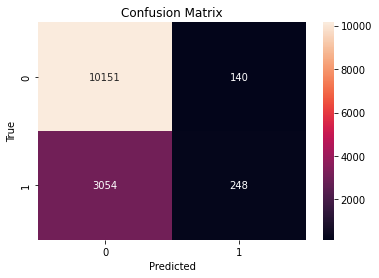

In [ ]:
from sklearn.linear_model import LogisticRegression
#Import label encoder
from sklearn import preprocessing
  
#label_encoder object knows how to understand word labels
label_encoder = preprocessing.LabelEncoder()

cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'subscribed_flag']
for c in cat_features:
    #Encode labels in column Sex and Embarked
    df[c]= label_encoder.fit_transform(df[c])

df.head()

target_col = "subscribed_flag"
X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = False)

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print("classification_report : " + str(classification_report(y_test, y_pred)))

print("accuracy_score : " + str(accuracy_score(y_test, y_pred)))
print("f1_score : " + str(f1_score(y_test, y_pred)))
print("precision_score : " + str(precision_score(y_test, y_pred)))
print("recall_score : " + str(recall_score(y_test, y_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn, fp, fn, tp")
print(tn, fp, fn, tp)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

10151 140 3054 248


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



classification_report :               precision    recall  f1-score   support

           0       0.81      0.34      0.48     10291
           1       0.27      0.76      0.40      3302

    accuracy                           0.44     13593
   macro avg       0.54      0.55      0.44     13593
weighted avg       0.68      0.44      0.46     13593

accuracy_score : 0.4398587508276319
f1_score : 0.3978171464726352
precision_score : 0.2692143010062085
recall_score : 0.7616596002422774
tn, fp, fn, tp
3464 6827 787 2515


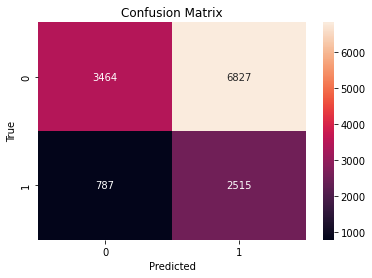

In [ ]:
#ros = RandomOverSampler()
#X_ros, y_ros = ros.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = False)

from sklearn.linear_model import LogisticRegression
w = {1:99, 0:1}
lr_model = LogisticRegression(random_state=0, class_weight=w)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print("classification_report : " + str(classification_report(y_test, y_pred)))

print("accuracy_score : " + str(accuracy_score(y_test, y_pred)))
print("f1_score : " + str(f1_score(y_test, y_pred)))
print("precision_score : " + str(precision_score(y_test, y_pred)))
print("recall_score : " + str(recall_score(y_test, y_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn, fp, fn, tp")
print(tn, fp, fn, tp)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Best score: 0.926120866234279 with param: {'class_weight': {0: 1.0, 1: 1000}}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



classification_report :               precision    recall  f1-score   support

           0       0.94      0.19      0.32     10291
           1       0.28      0.96      0.43      3302

    accuracy                           0.38     13593
   macro avg       0.61      0.58      0.38     13593
weighted avg       0.78      0.38      0.35     13593

accuracy_score : 0.3807842271757522
f1_score : 0.4307067974298275
precision_score : 0.27727945658799963
recall_score : 0.9642640823743186
tn, fp, fn, tp
1992 8299 118 3184


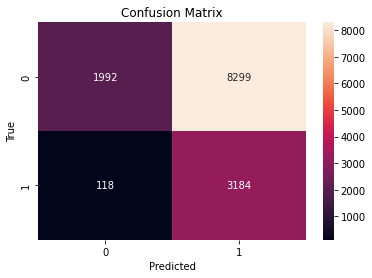

In [ ]:
#ros = RandomOverSampler()
#X_ros, y_ros = ros.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = False)

from sklearn.linear_model import LogisticRegression
# define weight hyperparameter
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }
lr_model = LogisticRegression(random_state=0)

# define evaluation procedure
grid = GridSearchCV(lr_model, hyperparam_grid, scoring="roc_auc", cv=3, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

w = grid.best_params_['class_weight']
lr_model = LogisticRegression(random_state=0, class_weight=w)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print("classification_report : " + str(classification_report(y_test, y_pred)))

print("accuracy_score : " + str(accuracy_score(y_test, y_pred)))
print("f1_score : " + str(f1_score(y_test, y_pred)))
print("precision_score : " + str(precision_score(y_test, y_pred)))
print("recall_score : " + str(recall_score(y_test, y_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn, fp, fn, tp")
print(tn, fp, fn, tp)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


8190 fits failed out of a total of 16380.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8190 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError

Best score: 0.9288890684943863 with param: {'C': 15.5, 'class_weight': {0: 1.0, 1: 1000}, 'fit_intercept': False, 'penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



classification_report :               precision    recall  f1-score   support

           0       0.85      0.08      0.15     10291
           1       0.25      0.95      0.40      3302

    accuracy                           0.29     13593
   macro avg       0.55      0.52      0.27     13593
weighted avg       0.70      0.29      0.21     13593

accuracy_score : 0.2926506290002207
f1_score : 0.3959288810705535
precision_score : 0.24978200554894966
recall_score : 0.9542701393095094
tn, fp, fn, tp
827 9464 151 3151


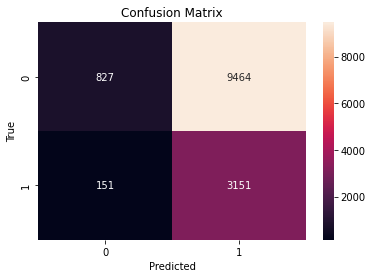

In [ ]:
#ros = RandomOverSampler()
#X_ros, y_ros = ros.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = False)

from sklearn.linear_model import LogisticRegression
# define weight hyperparameter
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }
lr_model = LogisticRegression(random_state=0)

# define evaluation procedure
grid = GridSearchCV(lr_model, hyperparam_grid, scoring="roc_auc", cv=3, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

lr_model = LogisticRegression(random_state=0, class_weight = grid.best_params_['class_weight'], C = grid.best_params_['C'], fit_intercept = grid.best_params_['fit_intercept'], penalty =grid.best_params_['penalty'])
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print("classification_report : " + str(classification_report(y_test, y_pred)))

print("accuracy_score : " + str(accuracy_score(y_test, y_pred)))
print("f1_score : " + str(f1_score(y_test, y_pred)))
print("precision_score : " + str(precision_score(y_test, y_pred)))
print("recall_score : " + str(recall_score(y_test, y_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("tn, fp, fn, tp")
print(tn, fp, fn, tp)

In [ ]:
grid.best_params_

{0: 1.0, 1: 1000}

In [ ]:
orig_df.groupby('subscribed_flag').agg({'subscribed_flag' : 'count'})

,subscribed_flag
subscribed_flag,
no,36548
yes,4640


In [ ]:
4640/(36548 + 4640)

0.11265417111780131

In [ ]:
result1 = resumetable(df)
result1

Dataset Shape: (41188, 18)


,Name,dtypes,Missing,Uniques,First Value,Second Value
0,age,int64,0,78,56,57
1,job,object,0,12,housemaid,services
2,marital,object,0,4,married,married
3,education,object,0,8,basic.4y,high.school
4,default,object,0,3,no,unknown
5,housing,object,0,3,no,no
6,loan,object,0,3,no,no
7,contact,object,0,2,telephone,telephone
8,month,object,0,10,may,may
9,day_of_week,object,0,5,mon,mon


In [ ]:
target_col = "subscribed_flag"
X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]
y = y.map({'yes': 1, 'no': 0}).astype(int)

#rus = RandomUnderSampler(sampling_strategy = "majority")
ros = RandomOverSampler(sampling_strategy=0.5)
X_ros, y_ros = ros.fit_resample(X,y)

In [ ]:
y_ros

0        0
1        0
2        0
3        0
4        0
        ..
54817    1
54818    1
54819    1
54820    1
54821    1
Name: subscribed_flag, Length: 54822, dtype: int64

In [ ]:
def objective(trial):
    cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']
    X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.33, random_state=42, shuffle = False)

    is_cat = (X.dtypes =='object')
    cat_features_index = np.where(is_cat)[0]
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    validation_pool = Pool(X_test, y_test, cat_features=cat_features)
    '''
    param = {"n_estimators": trial.suggest_int("n_estimators", 5, 10),
           "depth": trial.suggest_int("depth", 2, 3, 4, 5, 6, 7),
           "learning_rate": trial.suggest_discrete_uniform("learning_rate", .1, 1, .1)
            }
    '''
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 5),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model_cb = CatBoostClassifier(**param, random_state = 2021, use_best_model = True)
    model_cb.fit(X_train, y_train, cat_features = cat_features, plot=True, eval_set=(X_test, y_test))
    y_pred = model_cb.predict(X_test)
    #y_test_1 = y_test.map({'yes': 1, 'no': 0}).astype(int)
    #y_pred_1 = pd.Series(y_pred).map({'yes': 1, 'no': 0}).astype(int)
    accuracy, f1, precision, recall = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division = 1), precision_score(y_test, y_pred, zero_division = 1), recall_score(y_test, y_pred, zero_division = 1)
    return accuracy, f1, precision, recall

In [ ]:
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective, n_trials=5, timeout=120)
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-22 01:46:22,674] A new study created in memory with name: no-name-0e271793-3fb4-4a06-9398-8553d00d9319


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6594470	test: 0.7187170	best: 0.7187170 (0)	total: 31.5ms	remaining: 31.4s
1:	learn: 0.6287643	test: 0.7412653	best: 0.7187170 (0)	total: 66.3ms	remaining: 33.1s
2:	learn: 0.6012453	test: 0.7704146	best: 0.7187170 (0)	total: 89.1ms	remaining: 29.6s
3:	learn: 0.5757832	test: 0.7999252	best: 0.7187170 (0)	total: 112ms	remaining: 27.9s
4:	learn: 0.5522329	test: 0.8297043	best: 0.7187170 (0)	total: 135ms	remaining: 26.8s
5:	learn: 0.5304573	test: 0.8596650	best: 0.7187170 (0)	total: 159ms	remaining: 26.3s
6:	learn: 0.5043009	test: 0.8840914	best: 0.7187170 (0)	total: 183ms	remaining: 25.9s
7:	learn: 0.4727058	test: 0.9131235	best: 0.7187170 (0)	total: 216ms	remaining: 26.8s
8:	learn: 0.4558184	test: 0.9410192	best: 0.7187170 (0)	total: 260ms	remaining: 28.6s
9:	learn: 0.4407738	test: 0.9702813	best: 0.7187170 (0)	total: 291ms	remaining: 28.8s
10:	learn: 0.4266874	test: 0.9985532	best: 0.7187170 (0)	total: 327ms	remaining: 29.4s
11:	learn: 0.4067858	test: 1.0216444	best: 0.71871

[W 2021-12-22 01:46:54,123] Trial 0 failed, because the number of the values 4 did not match the number of the objectives 1.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6603739	test: 0.7209047	best: 0.7209047 (0)	total: 19.9ms	remaining: 19.9s
1:	learn: 0.6305489	test: 0.7502005	best: 0.7209047 (0)	total: 43.9ms	remaining: 21.9s
2:	learn: 0.6029401	test: 0.7799391	best: 0.7209047 (0)	total: 60.9ms	remaining: 20.2s
3:	learn: 0.5770685	test: 0.8093019	best: 0.7209047 (0)	total: 81.4ms	remaining: 20.3s
4:	learn: 0.5516171	test: 0.8337875	best: 0.7209047 (0)	total: 98.8ms	remaining: 19.7s
5:	learn: 0.5298792	test: 0.8639477	best: 0.7209047 (0)	total: 116ms	remaining: 19.2s
6:	learn: 0.5097839	test: 0.8941988	best: 0.7209047 (0)	total: 132ms	remaining: 18.8s
7:	learn: 0.4912099	test: 0.9244664	best: 0.7209047 (0)	total: 149ms	remaining: 18.5s
8:	learn: 0.4740436	test: 0.9546822	best: 0.7209047 (0)	total: 165ms	remaining: 18.2s
9:	learn: 0.4581790	test: 0.9847840	best: 0.7209047 (0)	total: 182ms	remaining: 18s
10:	learn: 0.4435169	test: 1.0147153	best: 0.7209047 (0)	total: 199ms	remaining: 17.9s
11:	learn: 0.4299655	test: 1.0444254	best: 0.72090

[W 2021-12-22 01:47:12,615] Trial 1 failed, because the number of the values 4 did not match the number of the objectives 1.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077174
0:	learn: 0.6092890	test: 0.7705035	best: 0.7705035 (0)	total: 39ms	remaining: 39s
1:	learn: 0.5396326	test: 0.8230924	best: 0.7705035 (0)	total: 70.9ms	remaining: 35.4s
2:	learn: 0.4876850	test: 0.9002717	best: 0.7705035 (0)	total: 94.9ms	remaining: 31.5s
3:	learn: 0.4454806	test: 0.9773603	best: 0.7705035 (0)	total: 118ms	remaining: 29.4s
4:	learn: 0.4111907	test: 1.0532944	best: 0.7705035 (0)	total: 142ms	remaining: 28.2s
5:	learn: 0.3833081	test: 1.1272626	best: 0.7705035 (0)	total: 166ms	remaining: 27.5s
6:	learn: 0.3606040	test: 1.1986715	best: 0.7705035 (0)	total: 190ms	remaining: 26.9s
7:	learn: 0.3420834	test: 1.2671111	best: 0.7705035 (0)	total: 223ms	remaining: 27.7s
8:	learn: 0.3258344	test: 1.3272679	best: 0.7705035 (0)	total: 252ms	remaining: 27.8s
9:	learn: 0.3135314	test: 1.3887683	best: 0.7705035 (0)	total: 275ms	remaining: 27.2s
10:	learn: 0.2857745	test: 1.3922954	best: 0.7705035 (0)	total: 321ms	remaining: 28.9s
11:	learn: 0.2785919	tes

[W 2021-12-22 01:47:49,231] Trial 2 failed, because the number of the values 4 did not match the number of the objectives 1.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6586300	test: 0.7114663	best: 0.7114663 (0)	total: 28.4ms	remaining: 28.3s
1:	learn: 0.6266267	test: 0.7293270	best: 0.7114663 (0)	total: 58.5ms	remaining: 29.2s
2:	learn: 0.5992252	test: 0.7577153	best: 0.7114663 (0)	total: 82ms	remaining: 27.3s
3:	learn: 0.5738724	test: 0.7864870	best: 0.7114663 (0)	total: 105ms	remaining: 26.3s
4:	learn: 0.5504235	test: 0.8155503	best: 0.7114663 (0)	total: 129ms	remaining: 25.8s
5:	learn: 0.5287420	test: 0.8448190	best: 0.7114663 (0)	total: 153ms	remaining: 25.4s
6:	learn: 0.5008314	test: 0.8674409	best: 0.7114663 (0)	total: 182ms	remaining: 25.8s
7:	learn: 0.4808213	test: 0.8830847	best: 0.7114663 (0)	total: 212ms	remaining: 26.2s
8:	learn: 0.4641122	test: 0.9116397	best: 0.7114663 (0)	total: 241ms	remaining: 26.6s
9:	learn: 0.4477910	test: 0.9366241	best: 0.7114663 (0)	total: 272ms	remaining: 27s
10:	learn: 0.4322225	test: 0.9631753	best: 0.7114663 (0)	total: 319ms	remaining: 28.7s
11:	learn: 0.4191322	test: 0.9911525	best: 0.7114663 (

[W 2021-12-22 01:48:22,307] Trial 3 failed, because the number of the values 4 did not match the number of the objectives 1.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077174
0:	learn: 0.6096223	test: 0.7637926	best: 0.7637926 (0)	total: 32.7ms	remaining: 32.7s
1:	learn: 0.5416143	test: 0.8075849	best: 0.7637926 (0)	total: 53.8ms	remaining: 26.8s
2:	learn: 0.4893632	test: 0.8830372	best: 0.7637926 (0)	total: 70.7ms	remaining: 23.5s
3:	learn: 0.4469126	test: 0.9586082	best: 0.7637926 (0)	total: 87ms	remaining: 21.7s
4:	learn: 0.4124236	test: 1.0332204	best: 0.7637926 (0)	total: 103ms	remaining: 20.6s
5:	learn: 0.3843806	test: 1.1060446	best: 0.7637926 (0)	total: 120ms	remaining: 19.9s
6:	learn: 0.3615471	test: 1.1764678	best: 0.7637926 (0)	total: 136ms	remaining: 19.3s
7:	learn: 0.3429224	test: 1.2440598	best: 0.7637926 (0)	total: 152ms	remaining: 18.9s
8:	learn: 0.3276996	test: 1.3085383	best: 0.7637926 (0)	total: 170ms	remaining: 18.7s
9:	learn: 0.3138500	test: 1.3220016	best: 0.7637926 (0)	total: 193ms	remaining: 19.1s
10:	learn: 0.3037026	test: 1.3782311	best: 0.7637926 (0)	total: 215ms	remaining: 19.3s
11:	learn: 0.2945256	

[W 2021-12-22 01:48:44,201] Trial 4 failed, because the number of the values 4 did not match the number of the objectives 1.


Number of completed trials: 5
Best trial:


ValueError: ignored

In [ ]:
study.trials

[FrozenTrial(number=0, values=None, datetime_start=datetime.datetime(2021, 12, 22, 1, 46, 22, 677918), datetime_complete=datetime.datetime(2021, 12, 22, 1, 46, 54, 123490), params={'objective': 'CrossEntropy', 'colsample_bylevel': 0.07646356915266643, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.305451281082085}, distributions={'objective': CategoricalDistribution(choices=('Logloss', 'CrossEntropy')), 'colsample_bylevel': UniformDistribution(high=0.1, low=0.01), 'depth': IntUniformDistribution(high=5, low=1, step=1), 'boosting_type': CategoricalDistribution(choices=('Ordered', 'Plain')), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian', 'Bernoulli', 'MVS')), 'bagging_temperature': UniformDistribution(high=10.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.FAIL, value=None),
 FrozenTrial(number=1, values=None, datetime_start=datetime.datetime(2021, 12, 22, 1, 46, 54, 127982)

In [ ]:
study

In [ ]:
optuna.visualization.plot_param_importances(study)

ValueError: ignored

In [ ]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
#study = optuna.create_study(direction="minimize")
#study.optimize(optimize, n_trials=10)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
validation_pool = Pool(X_test, y_test, cat_features=cat_features)
features = list(X_train.columns)
model_cb = CatBoostClassifier(iterations=100, random_state = 2021, eval_metric="F1",auto_class_weights='Balanced', one_hot_max_size = 10, use_best_model = True)

In [ ]:
model_cb.fit(X_train, y_train, cat_features = cat_features, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.195792
0:	learn: 0.8994691	test: 0.5184488	best: 0.5184488 (0)	total: 34.9ms	remaining: 3.45s
1:	learn: 0.9102654	test: 0.5184488	best: 0.5184488 (0)	total: 83.3ms	remaining: 4.08s
2:	learn: 0.9146228	test: 0.5200827	best: 0.5200827 (2)	total: 107ms	remaining: 3.47s
3:	learn: 0.9150974	test: 0.5667521	best: 0.5667521 (3)	total: 121ms	remaining: 2.9s
4:	learn: 0.9160727	test: 0.5248637	best: 0.5667521 (3)	total: 148ms	remaining: 2.81s
5:	learn: 0.9157633	test: 0.5279782	best: 0.5667521 (3)	total: 250ms	remaining: 3.92s
6:	learn: 0.9158012	test: 0.5340911	best: 0.5667521 (3)	total: 307ms	remaining: 4.08s
7:	learn: 0.9160557	test: 0.5340852	best: 0.5667521 (3)	total: 340ms	remaining: 3.9s
8:	learn: 0.9172053	test: 0.5292965	best: 0.5667521 (3)	total: 380ms	remaining: 3.85s
9:	learn: 0.9172053	test: 0.5315348	best: 0.5667521 (3)	total: 425ms	remaining: 3.83s
10:	learn: 0.9217184	test: 0.5318438	best: 0.5667521 (3)	total: 484ms	remaining: 3.92s
11:	learn: 0.9210537	te

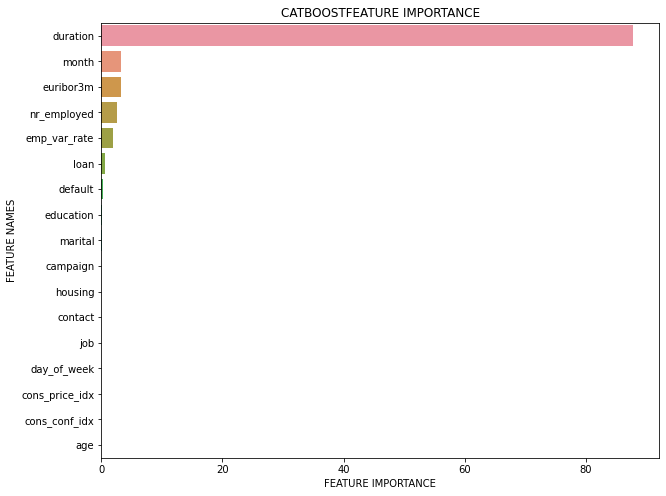

In [ ]:
#plot the catboost result
plot_feature_importance(model_cb.get_feature_importance(),X_train.columns,'CATBOOST')

In [ ]:
print(model_cb.get_best_score())

{'learn': {'Logloss': 0.17823831090916895, 'F1': 0.9418615185581457}, 'validation': {'Logloss': 0.747098271350063, 'F1': 0.5667520722002937}}


In [ ]:
model_cb.get_feature_importance()

array([0.00000000e+00, 0.00000000e+00, 1.46567630e-01, 1.56946301e-01,
       3.29739009e-01, 0.00000000e+00, 6.25392166e-01, 0.00000000e+00,
       3.23833095e+00, 0.00000000e+00, 8.77339217e+01, 1.27156675e-03,
       1.98331865e+00, 0.00000000e+00, 0.00000000e+00, 3.18019204e+00,
       2.60431995e+00])

In [ ]:
y_pred = model_cb.predict(X_test)

In [ ]:
y_test_1 = y_test.map({'yes': 1, 'no': 0}).astype(int)
y_pred_1 = pd.Series(y_pred).map({'yes': 1, 'no': 0}).astype(int)
f1_score(y_test_1, y_pred_1)

0.4451494406411754

In [ ]:
accuracy_score(y_test, y_pred), f1_score(y_test_1, y_pred_1), precision_score(y_test_1, y_pred_1), recall_score(y_test_1, y_pred_1), precision_recall_fscore_support(y_test_1, y_pred_1)

(0.7555359376149489,
 0.4451494406411754,
 0.49609229624116113,
 0.403694730466384,
 (array([0.81945718, 0.4960923 ]),
  array([0.86842872, 0.40369473]),
  array([0.84323253, 0.44514944]),
  array([10291,  3302])))

In [ ]:
precision_recall_curve(y_test_1, y_pred_1)

(array([0.24291915, 0.4960923 , 1.        ]),
 array([1.        , 0.40369473, 0.        ]),
 array([0, 1]))

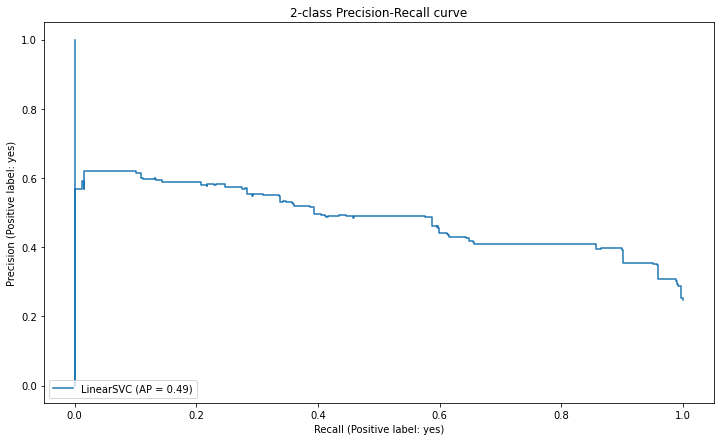

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display1 = PrecisionRecallDisplay.from_estimator(
    model_cb, X_test, y_test, name="LinearSVC"
)
_ = display1.ax_.set_title("2-class Precision-Recall curve")

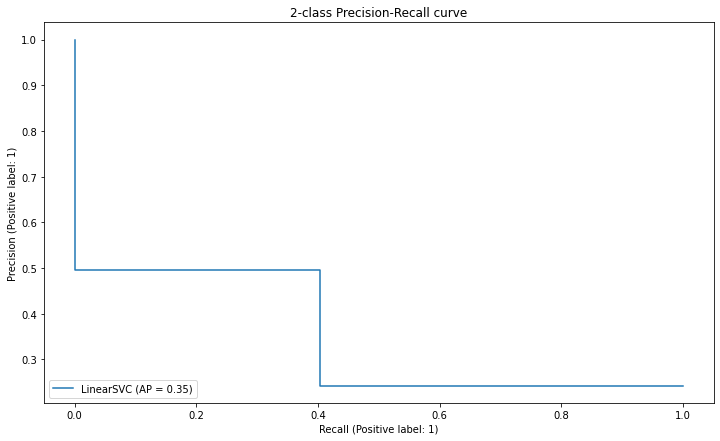

In [ ]:
display2 = PrecisionRecallDisplay.from_predictions(y_test_1, y_pred_1, name="LinearSVC")
_ = display2.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
precision, recall, threshold = precision_recall_curve(y_test_1, y_pred_1)
print(precision, recall, threshold)

[0.24291915 0.4960923  1.        ] [1.         0.40369473 0.        ] [0 1]


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_1)
print(fpr, tpr, thresholds)

[0.         0.13157128 1.        ] [0.         0.40369473 1.        ] [2 1 0]


In [ ]:
print("ROC AUC " + str(auc(fpr, tpr)))
print("PR AUC " + str(auc(recall, precision)))

ROC AUC 0.6360617272971314
PR AUC 0.522320497831077


In [ ]:
accuracy_score(y_test, y_pred)

0.7555359376149489

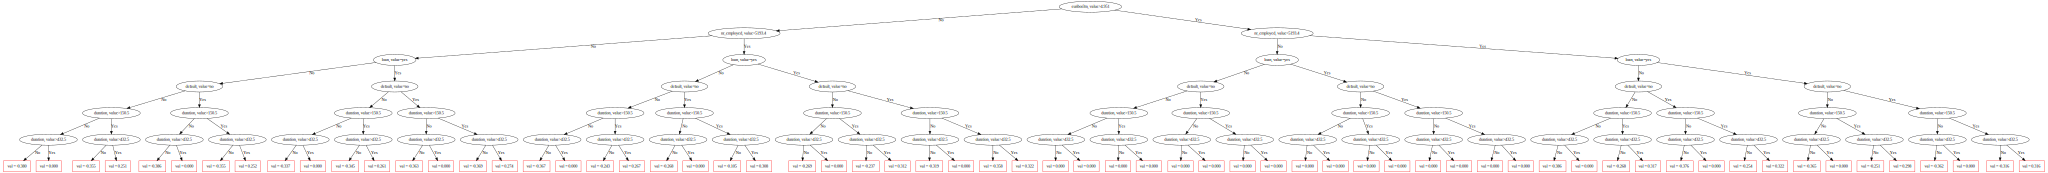

In [ ]:
is_cat = (X.dtypes =='object')
cat_features_index = np.where(is_cat)[0]
pool = Pool(X, y, cat_features=cat_features_index)

model_cb.plot_tree(
    tree_idx=0,
    pool=pool
)

In [ ]:
shap_values = model_cb.get_feature_importance(Pool(X_test, label=y_test,cat_features=cat_features_index), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

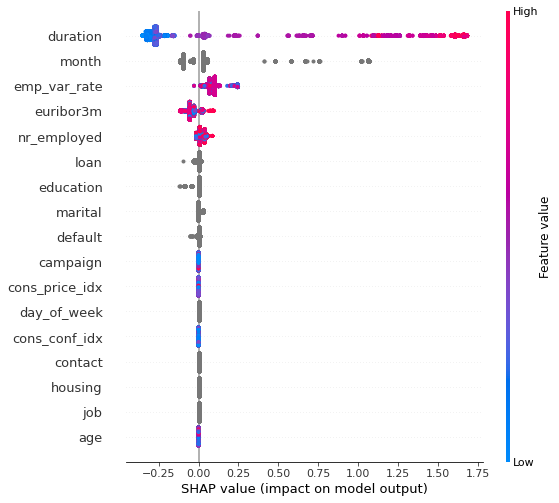

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(model_cb, X_test, y_test, log_loss)
    
    elif method == "Baseline":
        fi = baseline_importance(model_cb, X_train, y_train, X_test, y_test, log_loss)
    
    elif method == "ShapeValues":
        shap_values = model_cb.get_feature_importance(Pool(X_test, label=y_test,cat_features=cat_features_index), 
                                                                     type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, X_test) 
        
    else:
        fi = model_cb.get_feature_importance(Pool(X_test, label=y_test,cat_features=cat_features_index), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

In [ ]:
def log_loss(m, X, y): 
    return metrics.log_loss(y,m.predict_proba(X)[:,1])
    
def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

In [ ]:
def baseline_importance(model, X, y, X_test, y_test, metric):
    
    model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
    model.fit(X, y, cat_features = cat_features_index, verbose = False)
    baseline = metric(model, X_test, y_test)
    
    imp = []
    for col in X.columns:
        
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        
        model.fit(X, y, cat_features = cat_features_index, verbose = False)
        m = metric(model, X_test, y_test)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

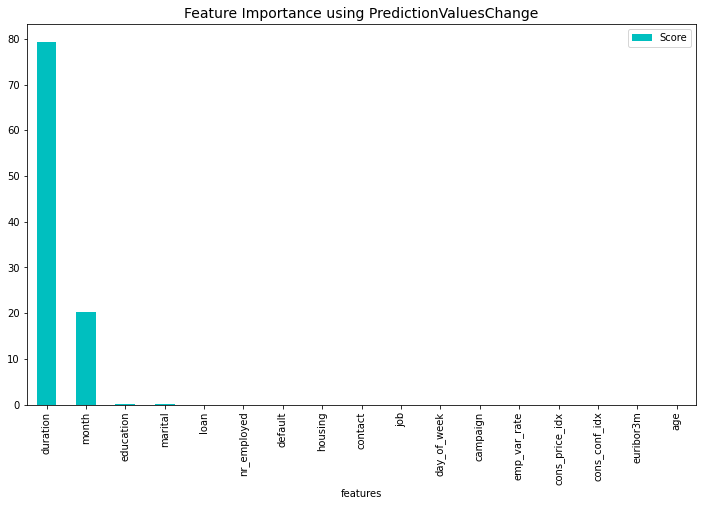

In [ ]:
get_feature_imp_plot(method="PredictionValuesChange")

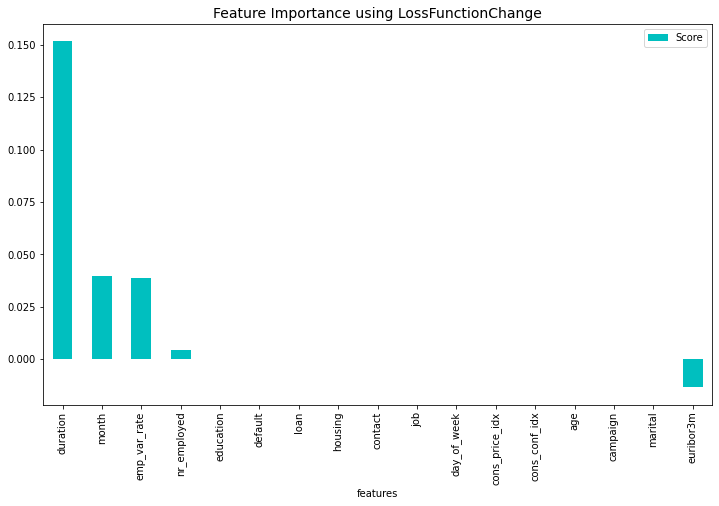

In [ ]:
get_feature_imp_plot(method="LossFunctionChange")

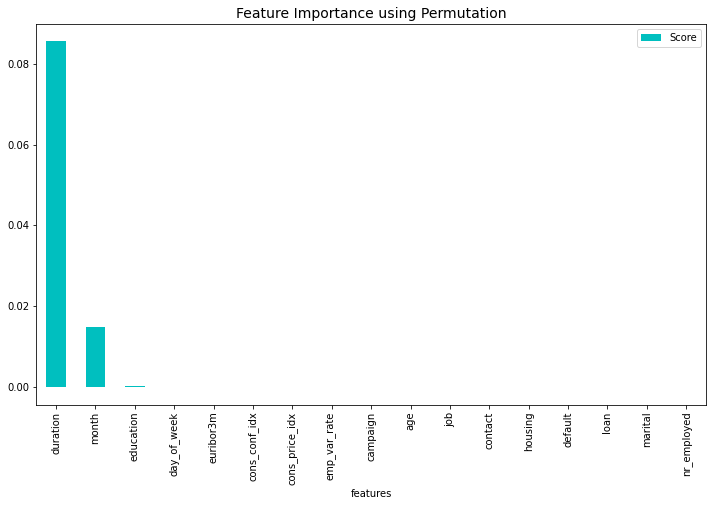

In [ ]:
get_feature_imp_plot(method="Permutation")

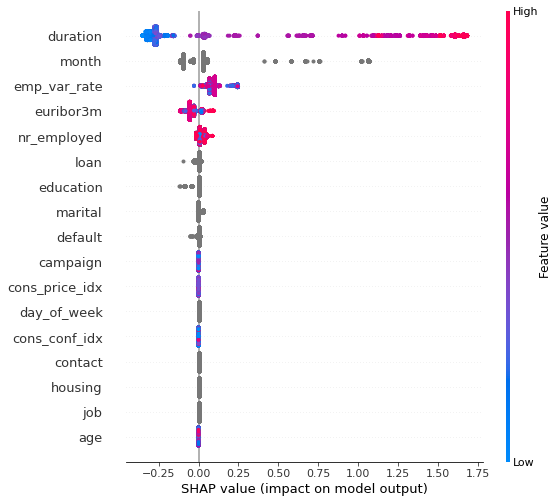

In [ ]:
get_feature_imp_plot(method="ShapeValues")

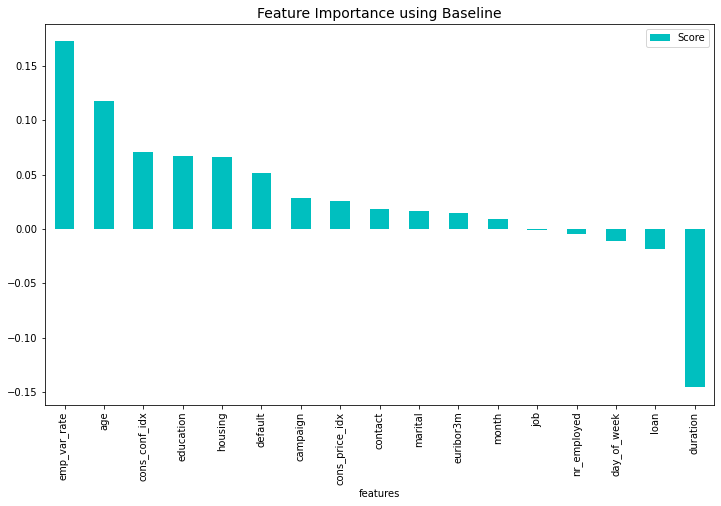

In [ ]:
get_feature_imp_plot(method="Baseline")